In [35]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [15]:
# Load the dataset
cath_df = pd.read_csv("./data/cath_moments.tsv", sep='\t', header=None) # For Train
ecod_df = pd.read_csv("./data/ecod_moments.tsv", sep='\t', header=None) # For eval

In [16]:
cath_info = cath_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Columns: 3924 entries, 0 to 3923
dtypes: float64(3923), object(1)
memory usage: 80.4+ MB


In [18]:
ecod_info = ecod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Columns: 3924 entries, 0 to 3923
dtypes: float64(3923), object(1)
memory usage: 22.8+ MB


In [20]:
# Summarize shapes, classes, and a preview
cath_summary = {
    "shape": cath_df.shape,
    "unique_classes": cath_df[0].nunique(),
    "class_distribution": cath_df[0].value_counts(),
    "head": cath_df.head()
}

ecod_summary = {
    "shape": ecod_df.shape,
    "unique_classes": ecod_df[0].nunique(),
    "class_distribution": ecod_df[0].value_counts(),
    "head": ecod_df.head()
}

In [21]:
print(cath_summary)

{'shape': (2685, 3924), 'unique_classes': 151, 'class_distribution': 0
3.40.640.10     91
2.130.10.10     84
1.10.510.10     74
3.30.70.330     68
3.20.20.120     68
                ..
3.30.40.10       1
3.30.365.10      1
1.10.238.10      1
1.10.3210.10     1
2.40.70.10       1
Name: count, Length: 151, dtype: int64, 'head':          0          1            2         3         4         5         6     \
0  1.10.10.10  19.690204  10396.13334  6.775472  7.824613  8.806157  9.508952   
1  1.10.10.10  17.433783   8254.98046  6.659365  7.399188  8.261971  8.929282   
2  1.10.10.10  18.131984   8404.89508  6.207462  7.314126  8.005369  8.952918   
3  1.10.10.10  19.040802   9139.38478  6.861197  7.672294  8.739374  9.184942   
4  1.10.10.10  19.353487   9677.95748  6.729898  7.402384  8.477378  9.060278   

        7          8          9     ...      3914      3915      3916  \
0  10.108499  11.329365  12.352082  ...  0.144626  0.131045  0.117448   
1   9.319409   9.944738  10.576600  ...

In [22]:
print(ecod_summary)

{'shape': (761, 3924), 'unique_classes': 34, 'class_distribution': 0
2003.1.1.417     76
206.1.1.24       68
11.1.1.1514      63
101.1.1.354      48
2111.78.1.7      46
2002.1.1.18      29
207.1.1.223      28
2111.84.1.8      28
2111.17.1.301    28
2003.1.2.20      27
3016.1.1.49      26
109.3.1.8        25
222.1.1.95       24
2111.17.1.212    21
2004.1.1.1404    18
2485.1.1.76      18
604.1.1.1        18
10.12.1.295      17
101.1.2.811      17
2005.1.1.145     15
223.1.1.180      12
367.1.1.1        12
7.1.1.3          12
2111.21.1.1      11
330.1.1.28       11
211.1.1.6        10
102.1.1.28       10
2003.1.2.56       8
389.1.2.3         8
386.1.1.55        7
132.1.1.2         6
389.3.1.1         6
64.1.1.1          6
376.1.1.27        2
Name: count, dtype: int64, 'head':           0          1            2         3          4          5     \
0  10.12.1.295  27.591259  18659.44800  8.453639   9.948058  11.270863   
1  10.12.1.295  27.608312  19255.88404  8.276176  10.616549  11.7190

In [43]:
for i in range(0,2):
    print(type(cath_df.iloc[0,i]))

<class 'str'>
<class 'numpy.float64'>


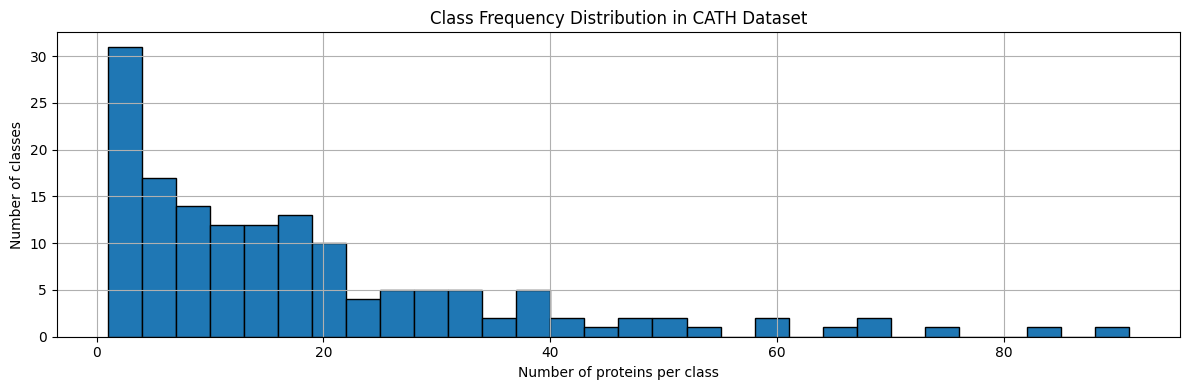

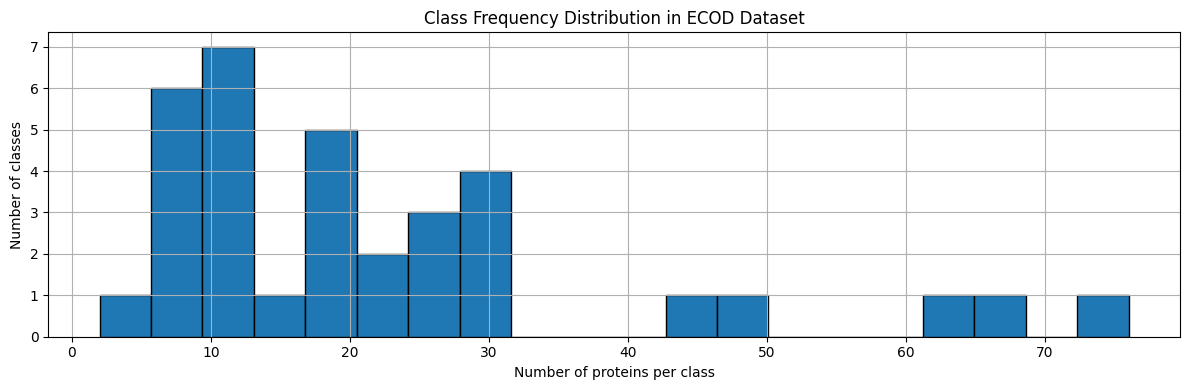

In [36]:
# Plot class distribution for CATH
cath_class_counts = cath_df[0].value_counts()
plt.figure(figsize=(12, 4))
plt.hist(cath_class_counts, bins=30, edgecolor='black')
plt.title('Class Frequency Distribution in CATH Dataset')
plt.xlabel('Number of proteins per class')
plt.ylabel('Number of classes')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot class distribution for ECOD
ecod_class_counts = ecod_df[0].value_counts()
plt.figure(figsize=(12, 4))
plt.hist(ecod_class_counts, bins=20, edgecolor='black')
plt.title('Class Frequency Distribution in ECOD Dataset')
plt.xlabel('Number of proteins per class')
plt.ylabel('Number of classes')
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualizing Class Imbalance

Each protein in the dataset is associated with a structural class label (column 0), which identifies its 3D(1D in this case) shape category. Understanding how many proteins fall into each class is critical because the dataset is not balanced—some classes have many proteins, while others have very few.

To quantify this, we use `value_counts()` to compute the frequency of each class label and visualize the distribution with a histogram.

#### Why this is important:
During training, we will create pairs of proteins to determine structural similarity. If a particular class contains many proteins, it will generate significantly more pairs, which may bias the model toward frequently occurring classes. This can lead to overfitting and poor generalization, especially on underrepresented classes.

By plotting the class frequency distribution:
- We confirm whether class imbalance is present.
- We motivate the need for sampling strategies such as `WeightedRandomSampler` to correct for this imbalance during training.

This analysis is a key step in understanding the structure of the data and informing how we design the training process.


In [1]:
import pandas as pd
import torch

from train import train_model, test_model_on_ecod

In [2]:
# Load datasets
cath_df = pd.read_csv("./data/cath_moments.tsv", sep='\t', header=None).dropna(axis=1)
ecod_df = pd.read_csv("./data/ecod_moments.tsv", sep='\t', header=None).dropna(axis=1)

print(f"CATH: {cath_df.shape}, ECOD: {ecod_df.shape}")


CATH: (2685, 3923), ECOD: (761, 3923)


In [8]:
from cache_utils import cache_pairwise_data
import time

# Only caching first 100 proteins for fast prototyping
tic = time.time_ns()
cache_pairwise_data(cath_df.head(100), "cached_cath_100.pkl")
tac = time.time_ns()
print((tac-tic)/(10**6),"ms")

Generating pairwise data from 100 proteins...
Saved 4950 precomputed protein pairs to: cached_cath_100.pkl
6170.247 ms


In [9]:
from cache_utils import cache_pairwise_data
import time

# Only caching first 100 proteins for fast prototyping
tic = time.time_ns()
num_items = 2685
cache_pairwise_data(cath_df.head(num_items), "cached_cath_"+str(num_items)+".pkl")
tac = time.time_ns()
print((tac-tic)/(10**6),"ms")

Generating pairwise data from 200 proteins...
Saved 19900 precomputed protein pairs to: cached_cath_100.pkl
24972.041 ms


In [11]:
# # Train logistic regression
# model_logistic = train_model(cath_df, hidden_dim=None, num_epochs=5, batch_size=8)

# Train small neural net
model_fcn = train_model(cath_df.head(200), hidden_dim=64, num_epochs=5, batch_size=8)

Training model (hidden_dim=64) for 5 epochs...


Epoch 1/5:   0%|          | 0/1590 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1590 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

